<div class="title">Aplicaciones de Análisis &ndash; TensorFlow: Práctica</div>
<div class="subtitle">Máster en Big Data y Data Science</div>


# Librerías

In [302]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow import keras

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Funciones

In [313]:
def plot_loss(train_loss: list, validation_loss: list):
    
    ''' Pinta dos curvas para comparar la evolucion en train y validacion durante el entrenamiento de un modelo NN.'''

    plt.plot(range(len(train_loss)), train_loss)
    plt.plot(range(len(validation_loss)), validation_loss)

    plt.legend(['train', 'validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.show()
    
    
def PlotHistory(history: keras.callbacks.History):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    return 1
    
    
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True


# Variables

In [3]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

PIC_HEIGHT = 150
PIC_WIDTH = 150
BATCH_SIZE = 32

# por sencillez, se delega el proceso de decision de los valores de optimizacion de las funciones en la variable AUTOTUNE de tensorflow
AUTOTUNE = tf.data.AUTOTUNE

# Carga de Datos y Preproceso

La función de Keras **tensorflow.keras.preprocessing.image.ImageDataGenerator** que crea los datos y los preprocesa está obsoleta. Se propone una metodología para crear un dataset más actual. 

In [4]:
train_data_dir = pathlib.Path(TRAIN_DIR)
test_data_dir = pathlib.Path(TEST_DIR)

len(list(train_data_dir.glob('*/*.jpg'))), len(list(test_data_dir.glob('*/*.jpg')))

(1008, 114)

La función **tensorflow.keras.utils.image_dataset_from_directory** contiene un método para hacer la división entre validación y train. Por tanto, se juntan ambas carpetas moviendo las imagenes de la carpeta validation a train.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
TRAIN_DIR,
validation_split=0.2,
subset="training",
seed=123,
image_size=(PIC_HEIGHT, PIC_WIDTH),
batch_size=BATCH_SIZE,
shuffle=True)

validation_ds = tf.keras.utils.image_dataset_from_directory(
TRAIN_DIR,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(PIC_HEIGHT, PIC_WIDTH),
batch_size=BATCH_SIZE,
shuffle=True)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 1011 files belonging to 4 classes.
Using 809 files for training.
Found 1011 files belonging to 4 classes.
Using 202 files for validation.


In [258]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    color_mode="rgb",
    batch_size=32,
    image_size=(PIC_HEIGHT, PIC_WIDTH),
    validation_split=None,
    subset=None,
    seed=123,
    shuffle=False)

Found 114 files belonging to 4 classes.


De esta forma tenemos un iterador sobre las imagenes seleccionadas para train y test del directorio data/train/

In [7]:
str(train_ds)

'<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>'

Se ve que los objetos sobre los que itera son tensores de orden $150 \times 150 \times 3$ de tipo entero, es decir, los píxeles de cada imagen en los canales de color RGB.

Se visualizan varias de las imágenes del conjunto de entrenamiento. 

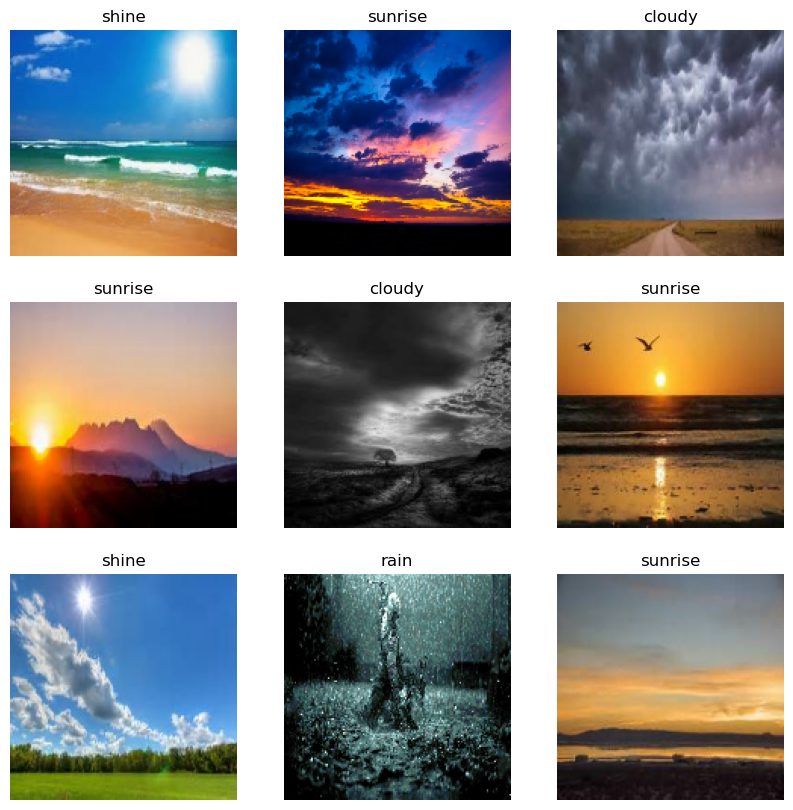

In [8]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1): # se itera sobre los objetos del conjunto de train
    for i in range(9): # se seleccionan las primeras 9 imagenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

Por otro lado, para mejorar el rendimiento se activan dos funcionalidades: 

1. **Cache:** Mantiene en memoria las imágenes despues de cargarlas durante la primera epoca de entrenamiento. Se espera que agilice el proceso de entreanmiento y que el proceso de carga de las imagenes no retrase el entrenamiento. 

2. **Prefetch:** Superpone el preprocesamiento y la ejecución de un modelo para agilizar la velocidad escritura y lectura (throughput) aunque consume mas memoria. En este caso al haber pocas imagenes no se espera overflow de memoria. 

El tamaño de buffer se delega en la variable AUTOTUNE de tensorflow. 

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Topología de la Red Neuronal

Se va a implementar una Red Neuronal Convolucional, especialmente indicada para problemas de clasificación multiclase de imágenes. Además, en este problema existen dos clases muy similares: shine y sunrise, que tienen elementos comunes como nubes o sol. **En este punto, la extracción de características locales de una red CNN puede ser superior a una arquitectura de perceptron.**

<img src="figures/topologia_practica.png">

Se han detectado varios aspectos que motivan la propuesta de arquitectura:

1. **Pares de clases similares**. Este punto motiva la creación de varias capas de extracción de características. Capas convolucionales con un filtro de tamaño grande que mire regiones grandes para poder diferenciar las clases rain-cloudy de shine-sunrise y capas con filtro pequeño que miren regiones locales pequeñas para poder diferenciar rain de cloudy y shine de sunrise. 

2. **Es un problema de clasificación**, por lo que se añadirá una capa oculta fully connected despues de las capas convolucionales antes de producir un output.

3. Por otro lado, los valores RGB de cada matriz del tensor tienen un rango [0, 255], sin embargo, para emplear modelos de redes neuronales, es deseable que los valores esten normalizados dentro de un mismo rango para que la superfice sobre la que optimizar la función de perdida sea lo mas suave y regular posible. **Se aplica una capa de escalado en el modelo.**

4. **Escalabilidad y eficiencia.** Para evitar tener una cantidad grande de capas extractoras de características (convolucionales), se añadirán capas Pooling para hacer una reducción del tamaño de dato (downsampling). Justo antes de ingestar los resultados de la extracción de características a la capa de clasificación, se hace un alisado de los tensores, es decir, se convierten en un vector.

In [234]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(PIC_HEIGHT, PIC_WIDTH, 3), name='Rescaling'),
  layers.Conv2D(filters=32, kernel_size=11, strides=2),
  layers.MaxPooling2D(pool_size=(4, 4)),
  layers.Conv2D(filters=18, kernel_size=5, strides=1),
  layers.MaxPooling2D(pool_size=(4, 4)),
  layers.Conv2D(filters=9, kernel_size=2, strides=1),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(124, activation='relu'),
  #layers.Dropout(rate=.5),
  #layers.Dense(32, activation='relu'),
  #layers.Dropout(rate=.2, seed=0),
  layers.Dense(8, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

**Nota:** Durante el entrenamiento se ha experimentado con varias topologias y se han eliminado varias capas o añadadido nuevas:

1. Se ha eliminado la capa de dropout. La intención es reducir la posibilidad de overfitting. Sin embargo, relentiza la convergencia durante el entrenamiento sustancialmente. La capa de dropout se tarda hasta 3 veces mas en llegar a la precision fijada (0.94).

2. Se ha eliminado una de las capas densas. Se relentiza la convergencia durante el entrenamiento y se llega al mismo resultado con menos parámetros. 

3. Se han añadido 3 capas convolucionales de mayor numero de filtros y tamaño de filtro a menor para extraer las features mas relevantes en cada capa convolucional. Ademas, para reducir el número de capas de convolucion necesarias se añaden capas de pooling intermedias en tamaño de filtro decreciente para reducir la dimension de los tensores de una capa convolucional a la siguiente. 

4. Se ha experimentado con dos funciones de perdida especialmente indicadas para problemas de clasificación: sigmoidal y relu. La función relu ha resultado en menor tiempo de aprendizaje. La capa final tiene la activación softmax para devolver la probabilidad de pertenencia a cada clase.  

In [235]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 70, 70, 32)        11648     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 17, 17, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 18)        14418     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 3, 3, 18)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 2, 2, 9)          

## Compilación y entrenamiento

In [236]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [237]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=1000,
  callbacks = [ThresholdCallback(threshold=0.94)]
)

Epoch 1/1000
26/26 [==============================] - 5s 173ms/step - loss: 1.1593 - accuracy: 0.4611 - val_loss: 0.8666 - val_accuracy: 0.5446
Epoch 2/1000
26/26 [==============================] - 4s 168ms/step - loss: 0.7506 - accuracy: 0.6625 - val_loss: 0.7905 - val_accuracy: 0.6535
Epoch 3/1000
26/26 [==============================] - 4s 163ms/step - loss: 0.6482 - accuracy: 0.7046 - val_loss: 0.6229 - val_accuracy: 0.7723
Epoch 4/1000
26/26 [==============================] - 4s 167ms/step - loss: 0.5674 - accuracy: 0.7417 - val_loss: 0.5977 - val_accuracy: 0.7327
Epoch 5/1000
26/26 [==============================] - 5s 175ms/step - loss: 0.5264 - accuracy: 0.7701 - val_loss: 0.5697 - val_accuracy: 0.7376
Epoch 6/1000
26/26 [==============================] - 4s 163ms/step - loss: 0.5298 - accuracy: 0.7577 - val_loss: 0.5217 - val_accuracy: 0.8020
Epoch 7/1000
26/26 [==============================] - 4s 168ms/step - loss: 0.4855 - accuracy: 0.7936 - val_loss: 0.4983 - val_accuracy:

## Visualización del proceso de aprendizaje

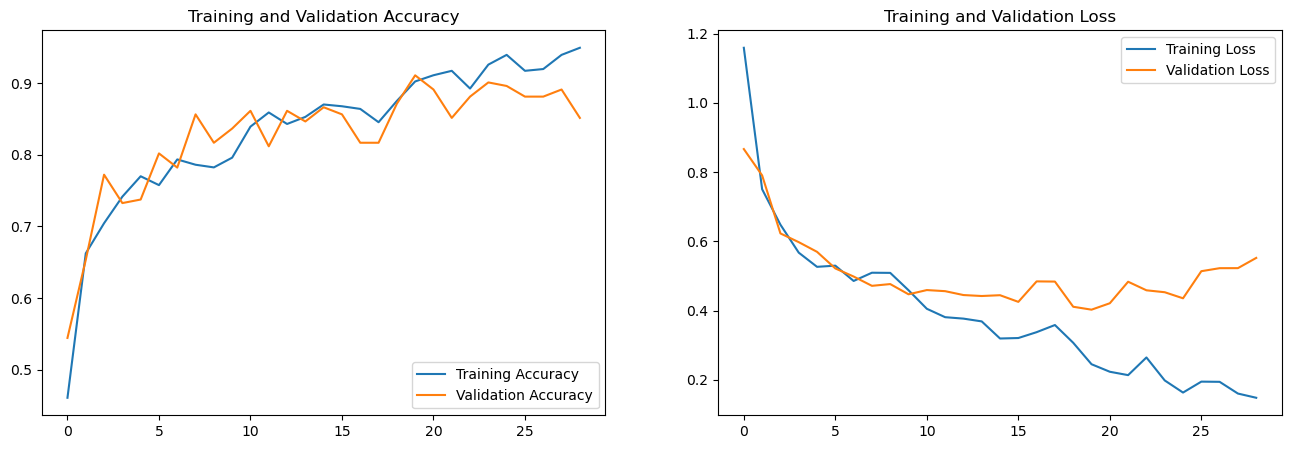

1

In [314]:
PlotHistory(history)

Se observa que la precisión aumenta con cada nueva epoca. Se observa un camino irregular. Esto puede deberse a que el learning rate es demasiado bajo y se ha caído en mínimos locales durante el proceso de entrenamiento. 


En la gráfica de la pérdida se observa que disminuye en cada nueva epoca. Se observa la misma irregularidad que en la precisión. Se ve que, aunque en training continua disminuyendo la perdida, en validación apenas cambia e incluso se aprecia que empieza a aumentar a medida que el modelo aprende muy bien los datos de entrenamiento. **Se ve que el modelo está proximo al overfitting si se sigue iterando en nuevas epocas y que gracias al criterio de parada se tiene un modelo con la mínima perdida.**

In [284]:
y_pred = model.predict(test_ds).argmax(axis=-1)
y_true = np.array([label.numpy() for pic, label in test_ds.unbatch()])

## Visualización de varias predicciones

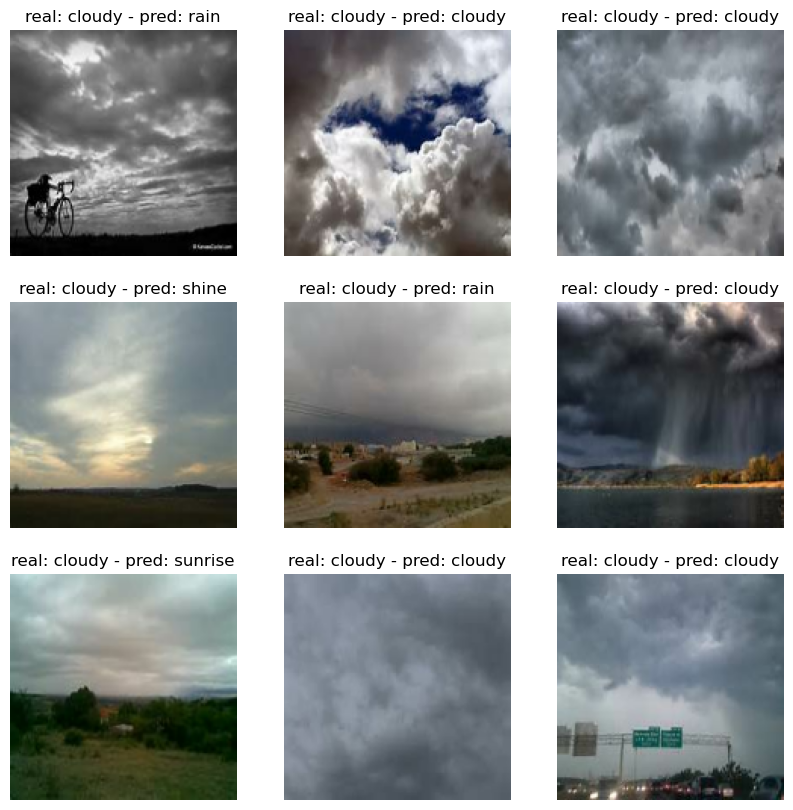

In [298]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1): # se itera sobre los objetos del conjunto de train
    for i in range(9): # se seleccionan las primeras 30 imagenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'real: {test_ds.class_names[labels[i]]} - pred: {test_ds.class_names[y_pred[i]]}')
        plt.axis("off")

Se ve que algunas de las imagenes estan incorrectamente clasificadas. Se entra a detalle en la siguiente sección.

## Diagnosis del modelo 

Para comprobar la calidad de las clasificaciones se calculan varias de las metricas habituales con el classification report de sklearn y se calcula la **matriz de confusion** para explicar los errores. 

In [278]:
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))

              precision    recall  f1-score   support

      cloudy       1.00      0.53      0.70        30
        rain       0.66      0.95      0.78        22
       shine       0.92      0.88      0.90        26
     sunrise       0.88      1.00      0.94        36

    accuracy                           0.84       114
   macro avg       0.86      0.84      0.83       114
weighted avg       0.88      0.84      0.83       114



Se observan varios hechos significativos para las clases:

1. **Cloudy:** Tiene recall muy bajo, es decir, cuando realmente es cloudy se acierta un 53% de las ocasiones. Por otro lado, tiene alta precision, es decir, cuando se predice cloudy, se acierta el 100% de las ocasiones. **Por tanto, esta clase tiene una tasa de falsos negativos muy alta. Se debe ver la matriz de confusion para ver qué otras clases confunden al clasificador.**
2. **Rain:** Mismo caso anterior pero a la inversa, con alto recall y baja precision. Por tanto, el modelo tiene altas posibilidades de confundir ambas clases. 
3. **Shine** y **Sunrise** tienen tanto precision como recall equilibrados y cercanos a 1 por lo que se asume que el modelo clasifica adecuadamente en estas clases. 

Se tiene en total un f1-socre de 0.84, un valor aceptable dada la complejidad del problema. 

Para terminar de comprobar los hechos del análisis anterior se pinta la matriz de confusión.

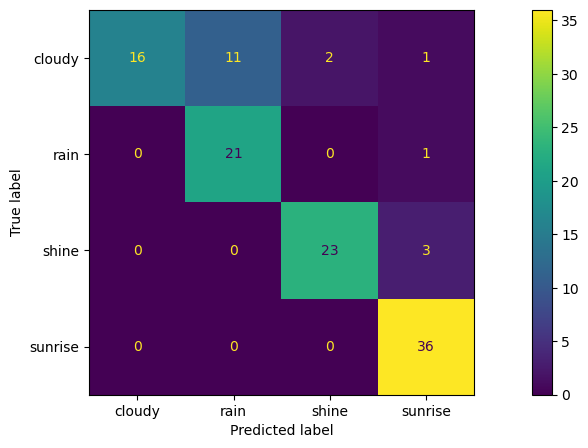

In [299]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names).plot()
plt.show()

Efectivamente se ve el modelo confunde la clase rain con cloudy. Tambien se observa que algunos casos de shine se han confundido con sunrise. Esto puede ser por varios motivos:

1. **rain y cloudy**. Cuando llueve, hay nubes. Esto hace que los dos fenomenos sean muy similares en cuanto a iluminación, paisaje, elementos, etc. Por tanto, una solución a este problema podría ser juntar ambas clases en una mas general que haga referencia al tiempo nublado o lluvioso. Tambien se hace difícil captar la lluvia dado que son particulas muy finas y apenas perceptibles en imagenes.

2. **shine y sunrise**. Existen algunas imagenes muy similares en cuanto a iluminacion, colorido y posicion de las nubes. Es posible que estos hechos confundan a al clasificador. 

Estos problemas tienen dificil solución ya que la frontera entre los distintos fenomenos es difusa en ocasiones. Para resolver este problema se puede hacer un aumento de datos para que las pequeñas diferencias entre algunos fenomenos sean mas comunes durante el entrenamiento y así se aprenda con mas ejemplos. 

Se guarda el último modelo entrenado durante la fase de experimentación. Se adjunta a la entrega todos los modelos propuestos. 

In [271]:
model.save(
    'trained_model_relus_2Dense_noDropOut',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: trained_model_relus_2Dense_noDropOut/assets


INFO:tensorflow:Assets written to: trained_model_relus_2Dense_noDropOut/assets


# Aumento de datos

Para intentar solucionar algunos de los problemas en los datos mencionados anteriormente, se plantea implementar un procedimiento de data augmentation. Existen dos formas de hacerlo:

1. Añadir neuronas de preprocesamiento en el modelo anterior. De esta forma el aumento corre sincronizadamente con el resto del modelo y el procedimiento se guarda al serializar el modelo con el resto de componentes.

2. Aplicar una pipeline de preprocesamiento sobre los datasets sin incluirla en el modelo. Se tiene el preprocesado como una componente independiente del proyecto para reutilizarse posteriormente y pueden solaparse las rutinas de entrenamiento y preprocesado. 

En este caso, se implementa en las capas del modelo para serializar el procedimiento en la entrega y porque requiere cambios minimos sobre el modelo ya generado. 

Se escogen las tecnicas de aumento de datos en relación a los problemas encontrados anteriormente:

1. **Similitud de elementos en varios fenomenos causa confusión:**

- Se generan imagenes rotadas aleatoriamente para aumentar el numero de imagenes disponibles para el entrenamiento. Se espera que un mayor numero de imagenes haga mas comun la similitud entre fenomenos y se pueda aprender la diferencia entre ambas (rain y cloudy).

2. **Similitud de colores e iluminación causa confusión:**

- Se generan imagenes alterando el brillo y contrate con la esperanza de resalzar la diferencia en las propiedades de los elementos de las imagenes. Se espera que pequeñas diferencias en ilumnicación permitan diferenciar mejor las clases de shine y sunrise. 

Se añaden por tanto dos nuevas capas de aumento: RandomRotation, RandomContrast.

**Las rotaciones de las imagenes seran de angulo comprendido entre 0 y 180 grados, y se rellenaran las partes vacías mediante la información del píxel más cercano por interpolación. Los cambios de contraste son a lo sumo de un 20% superior o inferior respecto a los valores originales.**

In [333]:
augmented_model = Sequential([

  layers.RandomRotation((0, np.pi), fill_mode='nearest', interpolation='bilinear', seed=123),
  layers.RandomContrast(factor=.2, seed=123),
  layers.Rescaling(1./255, input_shape=(PIC_HEIGHT, PIC_WIDTH, 3), name='Rescaling'),
  layers.Conv2D(filters=32, kernel_size=11, strides=2),
  layers.MaxPooling2D(pool_size=(4, 4)),
  layers.Conv2D(filters=18, kernel_size=5, strides=1),
  layers.MaxPooling2D(pool_size=(4, 4)),
  layers.Conv2D(filters=9, kernel_size=2, strides=1),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(124, activation='relu'),
  #layers.Dropout(rate=.5),
  #layers.Dense(32, activation='relu'),
  #layers.Dropout(rate=.2, seed=0),
  layers.Dense(8, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

augmented_model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [334]:
augmented_history = augmented_model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=1000,
  callbacks = [ThresholdCallback(threshold=0.94)]
)

Epoch 1/1000
26/26 [==============================] - 6s 196ms/step - loss: 1.2646 - accuracy: 0.4141 - val_loss: 1.0936 - val_accuracy: 0.3713
Epoch 2/1000
26/26 [==============================] - 5s 203ms/step - loss: 0.9456 - accuracy: 0.5562 - val_loss: 0.8926 - val_accuracy: 0.5545
Epoch 3/1000
26/26 [==============================] - 5s 203ms/step - loss: 0.9033 - accuracy: 0.6329 - val_loss: 0.9026 - val_accuracy: 0.6287
Epoch 4/1000
26/26 [==============================] - 6s 228ms/step - loss: 0.8204 - accuracy: 0.6761 - val_loss: 0.8093 - val_accuracy: 0.7228
Epoch 5/1000
26/26 [==============================] - 5s 196ms/step - loss: 0.8018 - accuracy: 0.6922 - val_loss: 0.8459 - val_accuracy: 0.7574
Epoch 6/1000
26/26 [==============================] - 5s 189ms/step - loss: 0.7652 - accuracy: 0.7145 - val_loss: 0.7573 - val_accuracy: 0.6931
Epoch 7/1000
26/26 [==============================] - 6s 219ms/step - loss: 0.7594 - accuracy: 0.7281 - val_loss: 0.8025 - val_accuracy:

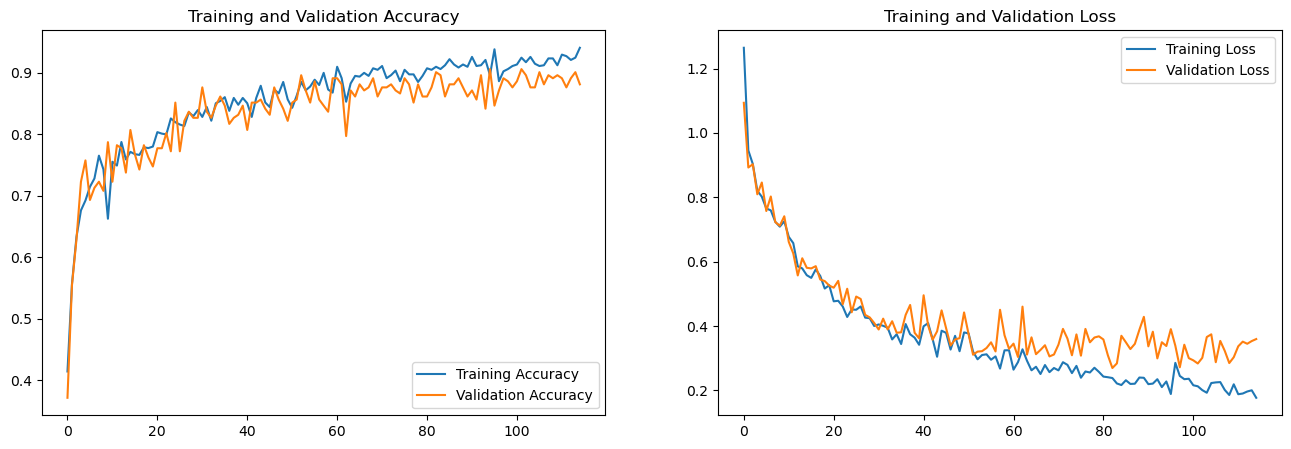

1

In [335]:
PlotHistory(augmented_history)

Se observan las mismas propiedades que en el modelo sin aumentos. Aplican los mismos comentarios. 

In [336]:
y_pred = augmented_model.predict(test_ds).argmax(axis=-1)

In [337]:
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))

              precision    recall  f1-score   support

      cloudy       0.85      0.77      0.81        30
        rain       0.74      0.91      0.82        22
       shine       0.96      0.85      0.90        26
     sunrise       0.97      1.00      0.99        36

    accuracy                           0.89       114
   macro avg       0.88      0.88      0.88       114
weighted avg       0.89      0.89      0.89       114



Se observa que ha mejorado el recall de cloudy y mejorado la precision de rain, sin deteriorarse la precision ni recall de ambos. Las capas de aumento parecen resolver el problema de confusion entre ambas clases.

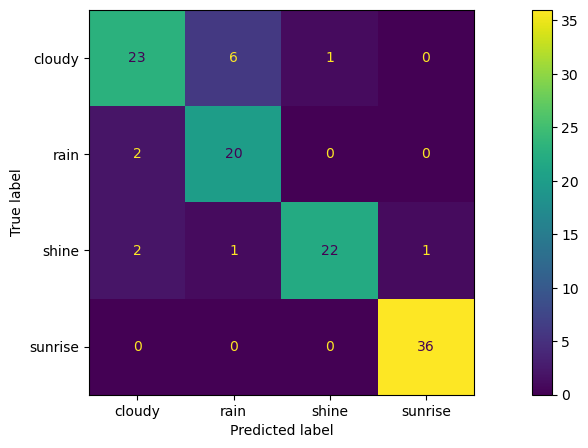

In [338]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names).plot()
plt.show()

En la matriz de confusion se confirma la mejora mencionada. 

Las razones por las que puede mejorar el resultado son:

1. Se ha visto mayor variedad de imagenes. Esto ha generado que las imagenes que generasen confusion entre clases han sido mas comunes en el entrenamiento y el modelo es capaz de discriminarlas mejor. 

2. El aumento de contraste arbitrario ha podido mejorar la detección de particulas de lluvia. Aunque estas particulas en el ambiente han podido generar confusion en la clase cloudy. Sin embargo, la confusion es menor que antes del aumento.

Se concluye que es necesaria una capa de aumento que resalte las diferencias entre imágenes de fenomenos muy similares.

In [339]:
augmented_model.save(
    'trained_model_relus_2Dense_noDropOut_Augmented',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: trained_model_relus_2Dense_noDropOut_Augmented/assets


INFO:tensorflow:Assets written to: trained_model_relus_2Dense_noDropOut_Augmented/assets


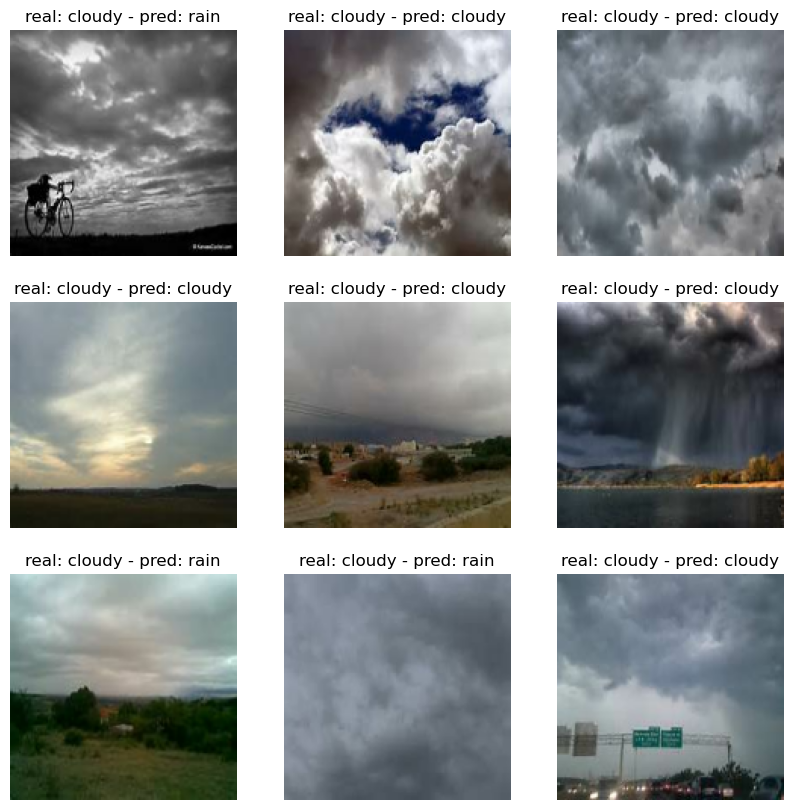

In [340]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1): # se itera sobre los objetos del conjunto de train
    for i in range(9): # se seleccionan las primeras 30 imagenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'real: {test_ds.class_names[labels[i]]} - pred: {test_ds.class_names[y_pred[i]]}')
        plt.axis("off")

# Conclusiones

Se ha visto como implementar un modelo de redes neuronales convolucionales desde cero para un problema de clasificación de imagenes supervisado. 

Destacaría varios varios puntos de aprendizaje importantes:

1. Crear un modelo de redes neuronales desde cero para un problema clásico de tratamiento de imágenes. 

2. Cómo tunear una red neuronal para mejorar varios aspectos: 

- Mejorar la topología para resolver el problema concreto
- Probar distintas funciones de activación para eficientar el entrenamiento y la precisión de resultados
- Implementar callbacks para alterar el comportamiento del modelo en tiempo de ejecución
- Implementar técnicas de aumento de datos para resolver problemas del baseline

3. Análisis de resultados 

- Analizar los resultados en clasificación para detectar inconsistencias e iterar el modelo hasta conseguir una versión que resuelva el problema en cuestión de manera aceptable. 